In [ ]:
# Only run on Google CoLab
# !git clone https://github.com/Holstrup/Mask_RCNN 
# import os
# os.chdir("Mask_RCNN/samples/wireframe")

# Mask R-CNN - One Shot Version

In the document we can run one-shot detection of wireframes using Mask R-CNN as the backbone of that analysis. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from samples.wireframe.WireframeGenerator import generate_data
import samples.wireframe.plots as plots

from samples.wireframe import Wireframe

%matplotlib inline 

Using TensorFlow backend.


## Data Preperation

First we need to generate some data, if the data is not already there. Note that, if you already have the data, you can simply skip this block. 
The function will create an additional 20% of images, that will be used as validation. 

In [115]:
NUM_TRAINING_IMAGES = 100
MAX_ICONS_PER_IMAGE = 3
generate_data(NUM_TRAINING_IMAGES, MAX_ICONS_PER_IMAGE)

In [2]:
config = Wireframe.WireframeConfig()
WIREFRAME_DIR = os.path.join(ROOT_DIR, "datasets/wireframe")

# Training dataset
dataset_train = Wireframe.WireframeDataset()
dataset_train.load_wireframe(WIREFRAME_DIR, "train")
dataset_train.prepare()


# Validation dataset
dataset_val = Wireframe.WireframeDataset()
dataset_val.load_wireframe(WIREFRAME_DIR, "val")
dataset_val.prepare()

## One Shot Inference 

Now we are ready to start detecting with our model. First we need to load the weights from the pretrained model, and initialize it in inference mode. The model file should be located in the **root folder**

In [3]:
MODEL_FILE_NAME = "mask_rcnn_20.h5"

class InferenceConfig(Wireframe.WireframeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, MODEL_FILE_NAME)
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  /Users/alexanderholstrup/git/Mask_RCNN/mask_rcnn_20.h5


Now we randomly pick an image and display it.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1334.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:  183.00000  max:  725.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


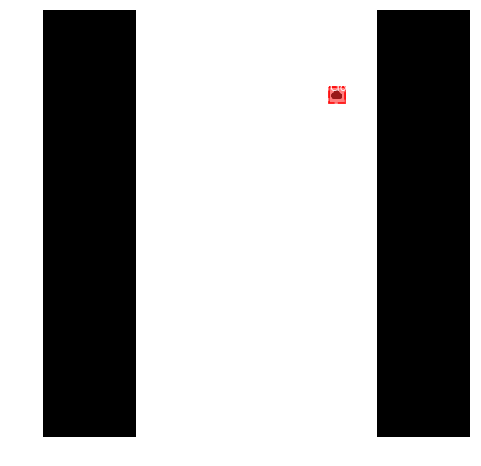

In [4]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


The next two functions might look similar in naming style, but they do different things. The OneShotAnchor function, is meant for you to tell our model "*hey! here's a new icon I'd like for you to be able to classify from now on*". Be aware, that the function only accepts images with **ONE** icon in it. <br/>
The OneShotDetect function is meant to detect all icons on a given image, and output their labels, based on the one-shots the models has been given before through the OneShotAnchor function. 

### Define an anchor

Please specify the label

In [13]:
LABEL = "Home"
model.OneShotAnchor(original_image, LABEL)

### Detect

For each icon on the image, it outputs the top 2 guesses, along with the normalized distance.

In [120]:
model.OneShotDetect(original_image)

({1.0: [(b'More', 0.16189241), (b'Home', 0.26391235)],
  2.0: [(b'Cross', 0.15089285), (b'Home', 0.19755729)],
  3.0: [(b'Home', 0.16844112), (b'Cross', 0.25407436)]},
 [(1, [(b'More', 0.16189241), (b'Home', 0.26391235)]),
  (2, [(b'Cross', 0.15089285), (b'Home', 0.19755729)]),
  (3, [(b'Home', 0.22605304), (b'Home', 0.26235175)]),
  (3, [(b'Home', 0.28646445), (b'Cross', 0.2970788)]),
  (2, [(b'Home', 0.31909424), (b'Cross', 0.32324028)]),
  (3, [(b'Home', 0.16844112), (b'Cross', 0.25407436)]),
  (3, [(b'Cross', 0.2353114), (b'Home', 0.25302583)])])

## Visualizations & Metrics

To be made

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


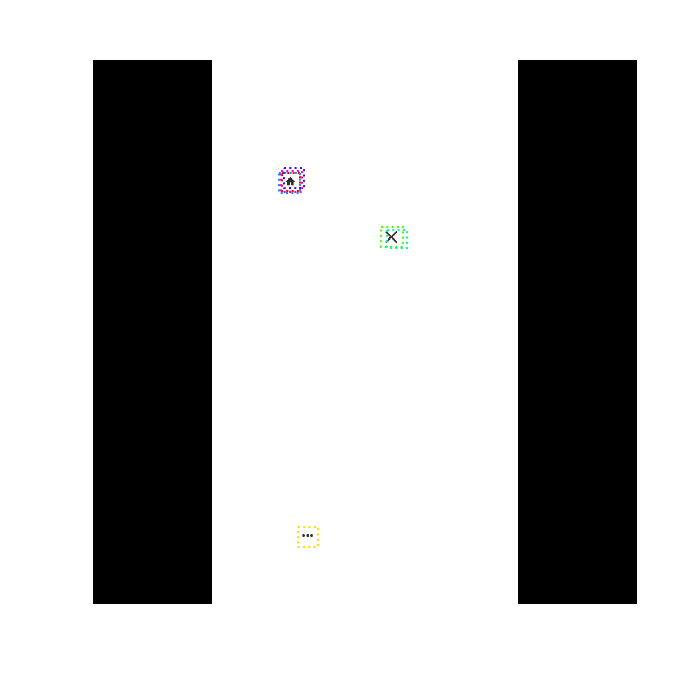

In [121]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.draw_boxes(original_image, r['rois'])

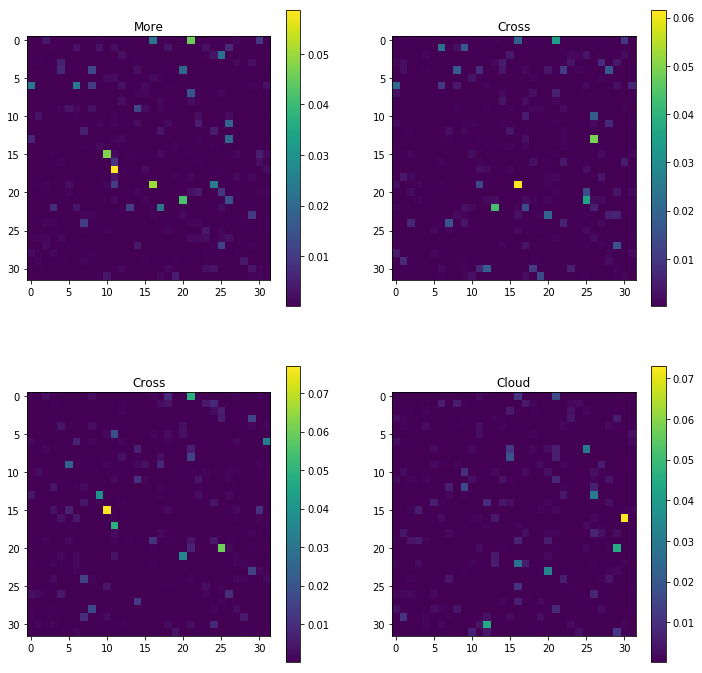

In [5]:
plots.feature_maps()

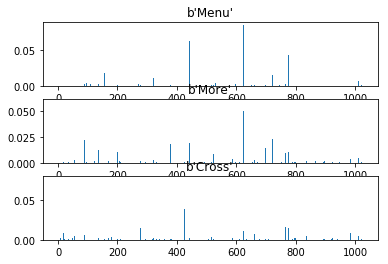

In [7]:
plots.plot_some_data()